In [1]:
import pandas as pd
import matplotlib.pyplot as plt 

from matplotlib.font_manager import FontProperties
from matplotlib.ticker import LinearLocator

raw_data = {'job_name': ['Default', '77 Tasks', '154 Tasks'], #x-axis
            'Onomi': [3073, 0, 0], #y-axis
            'Spark with 1Core, 2GB per executor': [2160, 1080, 840],
            'Spark with 3Cores, 6GB per executor': [1380, 1020, 840],
            'Spark with 6Cores, 12GB per executor': [1200, 960, 840]}
df = pd.DataFrame(raw_data, columns=['job_name', 'Onomi', 'Spark with 1Core, 2GB per executor', 'Spark with 3Cores, 6GB per executor', 'Spark with 6Cores, 12GB per executor'])

# Setting the positions and width for the bars
pos = list(range(len(df['Onomi'])))
width = 0.22

# Plotting the bars
fig, ax = plt.subplots(figsize=(14, 8))

rects1 = plt.bar(pos,
        df['Onomi'],
        width,
        #alpha=0.7,
        color='r',
        hatch=".")

rects2 = plt.bar([p + width for p in pos],
        df['Spark with 1Core, 2GB per executor'],
        width,
        #alpha=0.7,
        color='g',
        hatch="X")


rects3 = plt.bar([p + width * 2 for p in pos],
        df['Spark with 3Cores, 6GB per executor'],
        width,
        #alpha=0.7,
        color='y',
        hatch="O")

rects4 = plt.bar([p + width * 3 for p in pos],
        df['Spark with 6Cores, 12GB per executor'],
        width,
        #alpha=0.9,
        color='grey',
        hatch="*")


# Set the y axis label
ax.set_ylabel('Runtime (seconds)', fontsize=20)

# Set the chart's title
ax.set_title('Image Registration on Onomi Vs Spark', fontsize=25)

# Set the position of the x ticks
ax.set_xticks([p + 2 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(df['job_name'], fontsize=20)

# Setting the x-axis and y-axis limits
#plt.xlim(min(pos) - width, max(pos) + width * 4)
# plt.ylim([0, max(df['standalone'] + df['mesos'] + df['yarn'])] )
plt.xlim(-0.2, 2.9)
plt.ylim([0, 3300])
plt.yticks(fontsize=15)
# Set the y-ticks frequency to 10 evenly spaced values
ax.get_yaxis().set_major_locator(LinearLocator(numticks=11))


fontP = FontProperties()
fontP.set_size('x-large')

# Adding the legend and showing the plot
plt.legend(['Onomi', 'Spark with 1 Core, 2 GB per executor', 'Spark with 3 Cores, 6 GB per executor', 'Spark with 6 Cores, 12 GB per executor'], loc='upper right', shadow=False, prop=fontP)
#plt.grid()

def autolabel(rects, ax):
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in rects:
        height = rect.get_height()
        label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position, '%d' % int(height), ha='center', va='bottom')

autolabel(rects1, ax)
autolabel(rects2, ax)
autolabel(rects3, ax)
autolabel(rects4, ax)

plt.savefig("ImageRegOnomiVsSpark.pdf")
#plt.savefig("ImageRegOnomiVsSpark.eps", format="eps", dpi=5000)
plt.show()

ImportError: No module named 'pandas'

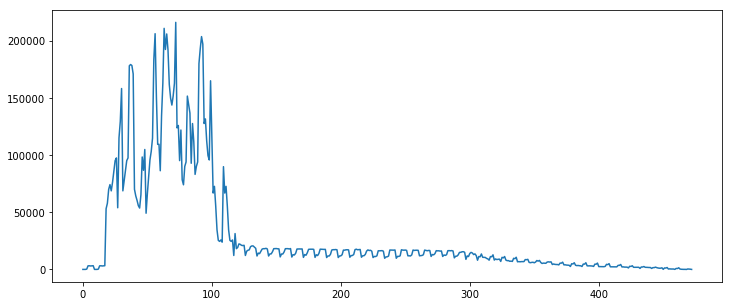

In [42]:
import json
import glob
import operator

from operator import itemgetter
from collections import Counter

log_files = glob.glob('app-20170610230853-0036/*.json')
result = []
file_system = []
sigar = []

def combine_dicts(a, b, op=operator.add):
    return dict(list(a.items()) + list(b.items()) + [(k, op(a[k], b[k])) for k in set(b) & set(a)])

for fileName in log_files:
    with open(fileName, "rb") as rawData:
        for line in rawData:
            result.append(json.loads(line))

sorted_result = sorted(result, key=itemgetter('timestamp'), reverse=False)

for i in range(len(sorted_result)):
    sigar.append({sorted_result[i]["timestamp"]: sorted_result[i]["values"]["sigar"]})
    file_system.append({sorted_result[i]["timestamp"]: sorted_result[i]["values"]["filesystem"]})

    
#################### Averaging sigar values ####################
sigar_previous_key = next(iter(sigar[0]))
sigar_previous_value = sigar[0][sigar_previous_key]

sigar_averaged_values_list = []
sigar_same_key_list = []
sigar_same_key_list.append(sigar_previous_value)

for i in range(1, len(sigar)):
    
    sigar_current_key = next(iter(sigar[i]))
    sigar_value = sigar[i][sigar_current_key]

    if sigar_current_key == sigar_previous_key:
        sigar_same_key_list.append(sigar_value)
    else:
        sigar_sums = Counter()
        sigar_counters = Counter()
        for itemset in sigar_same_key_list:
            sigar_sums.update(itemset)
            sigar_counters.update(itemset.keys())
        sigar_ret = {x: float(sigar_sums[x])/sigar_counters[x] for x in sigar_sums.keys()}
        sigar_averaged_values_list.append({sigar_previous_key: sigar_ret})

        sigar_same_key_list = []
        sigar_same_key_list.append(sigar_value)

    sigar_previous_key = sigar_current_key
    
sigar_averaged_timestamp = []
sigar_averaged_cpu = []
sigar_averaged_memory = []
sigar_kb_writes_disk = []
sigar_kb_read_disk = []
sigar_kb_writes_network = []
sigar_kb_read_network = []

for i in sigar_averaged_values_list:
    key = next(iter(i))
    sigar_averaged_timestamp.append(key)
    value = i[key]
    sigar_averaged_cpu.append(value["cpu"])
    sigar_averaged_memory.append(value["ram"])
    sigar_kb_writes_disk.append(value["kBytesWrittenPerSecond"])
    sigar_kb_read_disk.append(value["kBytesReadPerSecond"])
    sigar_kb_writes_network.append(value["kBytesTxPerSecond"])
    sigar_kb_read_network.append(value["kBytesRxPerSecond"])

    
plt.figure(figsize=(12, 5))
#plt.plot(sigar_averaged_cpu)
#plt.plot(sigar_averaged_memory)
plt.plot(sigar_kb_writes_network)
plt.show()
    
################# Averaging file system values #################

   


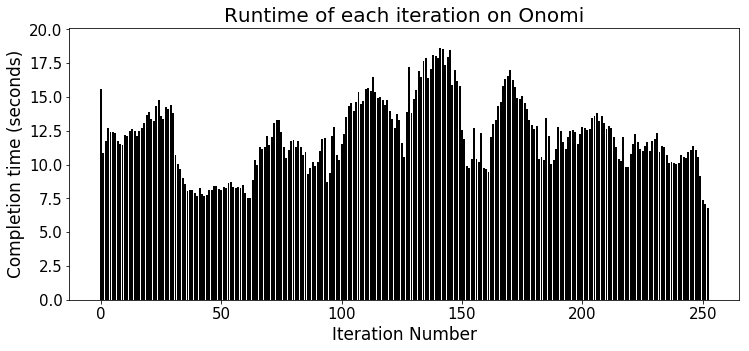

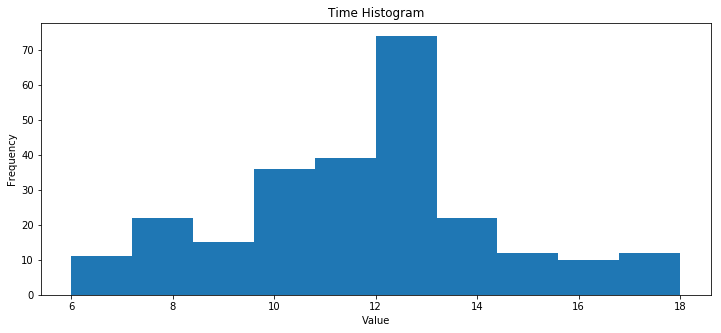

In [83]:
%matplotlib inline

import glob
import numpy as np
import matplotlib.pyplot as plt

log_files = glob.glob('OnomiResults/*.txt')

all_iteration_time = []

for fileName in log_files:
    
    iteration_time_list = []
    
    with open(fileName) as rawData:
        for line in rawData:
            if "Image proc. time:" in line:
                iteration_time = line.strip().split(" ")
                iteration_time_list.append(iteration_time[3])
    
    all_iteration_time.append(iteration_time_list) 

all_iteration_time = np.array([np.array(x, dtype=np.float64) for x in all_iteration_time])
all_iteration_time = np.mean(all_iteration_time, 0)

x = np.arange(0, len(all_iteration_time))

plt.figure(figsize=(12, 5))
plt.bar(x, all_iteration_time, color='k')
plt.title('Runtime of each iteration on Onomi', fontsize=20)
plt.xlabel('Iteration Number', fontsize=17)
plt.ylabel('Completion time (seconds)', fontsize=17)
plt.ylim(0, max(all_iteration_time) + 1.5)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.grid(False)
#plt.savefig("AveragedIterationTimeOnOnomi.png")
plt.show()


plt.figure(figsize=(12, 5))
(hist, _) = np.histogram(all_iteration_time, bins=np.arange(0, len(all_iteration_time)), range=(0, len(all_iteration_time)))
indiv_time = np.array(all_iteration_time)
plt.hist(all_iteration_time.astype(int))
plt.title("Time Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [41]:
from matplotlib.font_manager import FontProperties
from datetime import datetime, timedelta

import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

with open('cpu-load.csv', 'r') as f:
    reader = csv.reader(f)
    data_list = list(reader)

time_stamp_list = []
total_cpu_idle_list = []
total_cpu_user_list = []
total_cpu_wio_list = []

for index, line in enumerate(data_list):
    if index > 0:
        time_stamp = line[0]
        total_cpu_idle = (float(line[1]) + float(line[4]) + float(line[7]) + float(line[10]) + float(line[13]) + float(line[16]) + float(line[19]) + float(line[22]) + float(line[25]) + float(line[28]) + float(line[31])) / 11.0
        total_cpu_user = (float(line[2]) + float(line[5]) + float(line[8]) + float(line[11]) + float(line[14]) + float(line[17]) + float(line[20]) + float(line[23]) + float(line[26]) + float(line[29]) + float(line[32])) / 11.0
        total_cpu_woi = (float(line[3]) + float(line[6]) + float(line[9]) + float(line[12]) + float(line[15]) + float(line[18]) + float(line[21]) + float(line[24]) + float(line[27]) + float(line[30]) + float(line[33])) / 11.0

        time_stamp_list.append(datetime.strptime(time_stamp[0:19], "%Y-%m-%dT%H:%M:%S"))
        total_cpu_idle_list.append(total_cpu_idle)
        total_cpu_user_list.append(total_cpu_user)
        total_cpu_wio_list.append(total_cpu_woi)

fig, ax = plt.subplots(figsize=(12, 8))
        
"""
#plt.title("Image format conversion - YARN", fontsize=20)
plt.ylabel("CPU Utilization (%)", fontsize=15)
plt.xlabel("Timestamp", fontsize=15)
#plt.xlim([datetime(2017, 02, 01, 14, 22, 00), datetime(2017, 02, 01, 14, 35, 00)])
plt.ylim([-5, 105])

#ax.xaxis.set_major_locator(mdates.SecondLocator(interval=60))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:S'))

ax.plot_date(time_stamp_list, total_cpu_idle_list, fmt="r*-", label="cpu idle", )
ax.plot_date(time_stamp_list, total_cpu_user_list, fmt="b.-", label="cpu user")
ax.plot_date(time_stamp_list, total_cpu_wio_list, fmt="k*-", label="cpu woi", )

# font of the legend
fontP = FontProperties()
fontP.set_size('large')

ax.legend(loc='upper right', shadow=False, prop=fontP)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.grid(True)
fig.autofmt_xdate()

"""
plt.stackplot(time_stamp_list, [total_cpu_idle_list, total_cpu_user_list], colors=['#377EB8','#55BA87'])

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'cpu-load.csv'